- 앞의 0~3을 정리하여 처음부터 직접 작성한 코드
- 작업환경 : colab, gpu
- task : multi classificaion
- dataset : cifar10
    - 이미지가 하나에 32x32x3(채널) 크기임. 그리고 배치 하나당 미니 배치 개수만큼 이미지 갖게됨
    - 즉 input dim은 32x32x3

- 만약 제가 하이퍼파라미터를 튜닝한다면 일반적으로..
    - 레이어 수랑 히든 유닛 수를 조절해서 적절한 (성능이 나오면서 파라미터 수는 작은) Model Capacity를 찾구요
    - Learning Rate를 조절하면서 적절한 속도로 학습이 되는 값을 찾습니다. (값이 너무 크면 loss가 요동치거나 발산합니다)
    - Dropout과 l2 값을 조절하면서 Overfitting을 최대한 줄여보구요.
    - BatchNormalization과 Xavier Initialization을 껐다 켜보면서 성능 변화가 어느 정도 일어나는지 확인해봅니다.
- 이런 식으로 4~5개 정도의 실험을 거치면서 점점 하이퍼파라미터 영역을 좁혀나가면 그나마 안정적으로 값을 올릴 수 있었던 것 같습니다 :)
- 시간이 되시는 분들은 Random Search를 해봐도 재밌을 것 같네요!(하지만 시각화는 쉽지 않겠죠?)
- 그리고 추가로..
    - Optimizer를 바꿔보세요!
    - Activation Function을 바꿔보세요!

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time

### 0. Data Preparation
- dataset부분에서 partition이라는 dict을 쓰는 이유는 batch size도 hyper param으로 쓰기위함임
- 그래서 partition['train']하면 그냥 train에 해당하는 데이터셋임 ㅇㅇ

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
dataset_partition = {'train' : trainset, 'val' : valset, 'test' : testset}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### 이미지 확인 

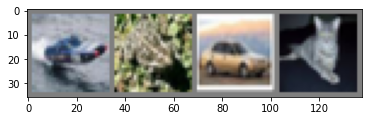

 ship  frog   car   cat
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([8, 6, 1, 3])
4


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print(type(images), images.shape) # 이미지가 하나에 batch*32*32*3(채널) 크기임. 그리고 배치 하나당 4개씩 이미지 갖게됨. # 즉 input dim은 32*32*3
print(type(labels), labels.shape, labels) # batch 수 만큼 있음 : 몇번째 label에 해당하는 이미지인가
print(labels.size(0))

### 1. Model Architecture

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_hid_layer, act_fn, dp_ratio, use_bn):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_hid_layer = n_hid_layer
        self.act_fn = act_fn
        self.dp_ratio = dp_ratio
        self.use_bn = use_bn

        # ====== Create Layers ========
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        self.linears = nn.ModuleList() # linears가 아닌 self.linears로 정의이유 => 밑에 다른 함수인 def forward에서도 사용위함
        self.bns = nn.ModuleList() # nn.ModuleList() : layer들을 리스트 처럼 받을 수 있는 자료구조 
        for _ in range(self.n_hid_layer):
            hid_layer = nn.Linear(self.hid_dim, self.hid_dim)
            self.linears.append(hid_layer)
            if self.use_bn == True : # 배치정규화도 (첫 층, 마지막 층 제외) 히든층 수 만큼 쓴다
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
        
        # ====== Create Activation Function ========
        if self.act_fn == 'relu':
            self.act_fn = nn.ReLU()
        elif self.act_fn == 'tanh':
            self.act_fn = nn.Tanh()

        # ====== Create Regularization Layer ======
        self.dropout = nn.Dropout(self.dp_ratio)

    def forward(self, x):
        x = self.act_fn(self.fc1(x))
        for i in range(len(self.linears)):
            # 층마다 bn, dropout 따로 사용
            # 순서 : 활성화 => 배치정규화 => 드롭아웃 (근데 배치정규화가 활성화하기전에 하는거 아닌가?)
            x = self.act_fn(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x) # 마지막엔 활성화함수 적용 x
        return x


In [5]:
# 실험삼아 한번 모델 생성해보고 정보 출력해보기 (추후 밑에서 args 설정해서 호출해줄것임)
model = MLP(3072, 10, 100, 4, 'relu', 0.1, True) 
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act_fn): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


### 2. Train, Validate, Test, and Experiment

#### 2-1. Train
- 인자 : 모델, 데이터셋, 옵티마이저, 목적함수 => 출력 : 학습된 모델 !
- train 함수에서는 return model 중요! 
    - 자칫 잘못하면 학습 실컷시키고 (return model 미포함하면) 쌩 model 사용하게 될 수 있음

In [6]:
def train(model, dataset_partition, optimizer, loss_fn, args) : 
    train_loader = torch.utils.data.DataLoader(dataset_partition['train'],
                                              batch_size = args.train_batch_size,
                                              shuffle = True, # train만 True고 valid, test는 False
                                              num_workers = 2)
    model.train()
    correct = 0 # 몇개 맞췄는지
    total = 0 # 관찰한 이미지 전체개수인듯
    train_loss = 0.0 # 분류 task여도 딥러닝이니까 연산 loss로 하므로..?
    for data in train_loader : 
        optimizer.zero_grad()

        inputs, labels = data # [batcj size,3,32,32] 이 형태라서 우리가 설정한 크기와 다름!
        inputs = inputs.view(-1, 3072) # [batchsize, 3072]
        inputs, labels = inputs.cuda(), labels.cuda()
        preds = model(inputs) # 표기 batchsize만큼 여러개있기때문에 pred -> preds, label -> labels와 같이하는게 좋음

        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, class_predicted = torch.max(preds.data, 1)
        total += labels.size(0) # 근데 이기 미니배치 사이즈랑 같은듯?
        correct += (class_predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader) # 배치의 수로 나눔 (미니배치 개수와 다른 개념)
    train_acc = correct / total * 100
    return model, train_loss, train_acc


#### 2-2. Validate
- 인자 : 학습된 모델, 데이터셋, 목적함수
    - 옵티마이저 X : 학습을 안하니까
- loss.backward(), optimizer.step() 이거만 안한다 뿐이지 나머지는 같음

In [7]:
def validate(model, dataset_partition, loss_fn, args):
    val_loader = torch.utils.data.DataLoader(dataset_partition['val'], 
                                            batch_size=args.validate_batch_size, 
                                            shuffle=False, # validate부턴 shuffle = False
                                            num_workers=2)
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in val_loader :
            inputs, labels = data 
            inputs = inputs.view(-1, 3072) 
            inputs, labels = inputs.cuda(), labels.cuda()
            preds = model(inputs)

            loss = loss_fn(preds, labels)
            val_loss += loss.item()
            _, class_predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (class_predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total * 100
    return val_loss, val_acc
            

#### 2-3. Test
- 인자 : 학습된 모델, 데이터셋
    - 옵티마이저, 목적함수 X
- 그냥 테스트셋을 활용해서 성능만 확인하는 것이므로

In [8]:
def test(model, dataset_partition, args):
    test_loader = torch.utils.data.DataLoader(dataset_partition['test'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, # validate부턴 shuffle = False
                                            num_workers=2)
    model.eval()
    correct = 0
    total = 0
    # val_loss = 0
    with torch.no_grad():
        for data in test_loader :
            inputs, labels = data 
            inputs = inputs.view(-1, 3072) 
            inputs, labels = inputs.cuda(), labels.cuda()
            preds = model(inputs)

            # loss = loss_fn(preds, labels)
            # val_loss += loss.item()
            _, class_predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (class_predicted == labels).sum().item()

        # val_loss = val_loss / len(test_loader)
        test_acc = correct / total * 100
    return test_acc
            

#### 2-4. Experiment
- train val test를 순차적으로 돌리고 결과를 epoch별로 리스트에 append해서 저장
- 각 결과는 result라는 dict에 저장

In [9]:
def experiment(dataset_partition, args):
  
    model = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_hid_layer, args.act, args.dropout, args.use_bn)
    model.cuda()

    loss_fn = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch): 
        ts = time.time()
        model, train_loss, train_acc = train(model, dataset_partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, dataset_partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts)) # 이렇게짜면 모든 에폭마다 다 출력이긴 함
        
    test_acc = test(model, dataset_partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result # 본 실험에 사용한 arguments와 result를 저장함
    # ===================================== #

### 3. Manage Experiment Result
- reference : https://www.youtube.com/watch?v=7CMxgqvrDgg&list=PLSAJwo7mw8jn8iaXwT4MqLbZnS-LJwnBd&index=17
- 각 실험결과들을 dict에 넣고 하나씩 append?
    - 인터넷 튕기거나 코랩 문제있으면 실험결과 다 날라감
- 하드디스크 저장방식을 사용하면 **중간에 프로세스 멈춰도 결과확인** 가능
    - **JSON 활용**하기!
    - 파라미터들을 JSON 파일명으로 쓰면 파라미터 많은경우 파일명으로 못쓰는경우 발생
    - HASH 이용
        - **deterministic하다**
        - 하나의 input => 같은 result
    - **내가 설정한 실험명 + hash 값을 통해서** 무슨 파라미터를 비교한 실험인지 알 수 있음!
- 앞에는 다 같곡 "Manage Experiment Result" 이 부분만 보면 됨!
- del epoch
    - 같은 셋팅값이여도 학습이 잘되어서 epoch 수를 늘릴 수 있는데 그러면 epoch 바꿀때마다 파일이 계속 생겨버려서 살펴보고자하는 하이퍼파라미터 조정별 결과와는 좀 다른의미니까 삭제
- del test_batch_size
    - 테스트 배치 사이즈도 실험에 영향을 미치는 값은 아니니까

In [10]:
!mkdir results # results라는 폴더에서 관리하기위해 폴더 생성

In [11]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6] # 기타 자잘한 파라미터값들 등등다해서 hash 값이 생성됨!
    filename = './results/{}-{}.json'.format(exp_name, hash_key) # 설정한 실험명-hash값 이렇게 파일명이 설정됨 (주요 파라미터로 실험이름 정하고)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

#### 3-1. Experiment
- setattr 쓰는이유 : 지금은 n_hid_layer지만 lr을 바꾼건 할때 위에는 바꿨지만 밑에는 안바꾸는 실수방지..
    - 이러면 3시간 돌아가도 결과기록은 기존대로 되는 문제 발생 가능!
- args.name_var1 = var1 이거랑 같은 문법이다.

In [12]:
from copy import deepcopy

# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_hid_layer_hid_dim" # 실험1 : 레이어수, hid_dim을 조정한 실험이란뜻으로 이런식으로 정의.

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024
args.validate_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_hid_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # args.name_var1 = var1 랑 같음
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(dataset_partition, deepcopy(args))
        save_exp_result(setting, result)


Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_hid_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_hid_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, validate_batch_size=1024)
Epoch 0, Acc(train/val): 36.98/40.14, Loss(train/val) 1.79/1.70. Took 12.37 sec
Epoch 1, Acc(train/val): 46.59/37.13, Loss(train/val) 1.52/1.85. Took 10.38 sec
Epoch 2, Acc(train/val): 50.22/41.62, Loss(train/val) 1.40/1.71. Took 9.54 sec
Epoch 3, Acc(train/val): 53.64/47.27, Loss(train/val) 1.31/1.53. Took 9.61 sec
Epoch 4, Acc(train/val): 56.04/42.68, Loss(train/val) 1.25/1.74. Took 9.39 sec
Epoch 5, Acc(train/val): 58.47/49.35, Loss(train/val) 1.18/1.55. Took 12.03 sec
Epoch 6, Acc(train/val): 60.44/45.00, Loss(train/val) 1.11/1.70. Took 9.56 sec
Epoch 7, Acc(train/val): 62.37/48.54, Loss(train/val) 1.06/1.61. Took 10.71 sec
Epoch 8, Acc(train/val): 64.84/49.61, Loss(train/val) 1.00/1.55. Took 9.56 sec
Epoch 9, Acc(train/val): 66.8

#### 3-2. Visualize

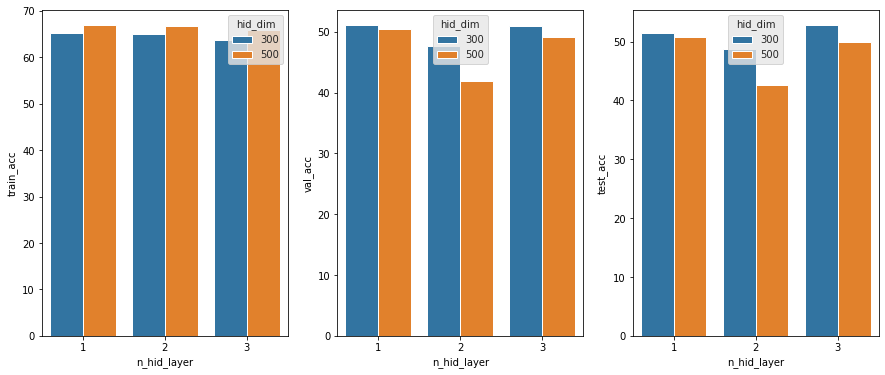

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# n_hid_layer와 hid_dim이 얼마나 영향을 미치는지 확인
sns.barplot(x='n_hid_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_hid_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_hid_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

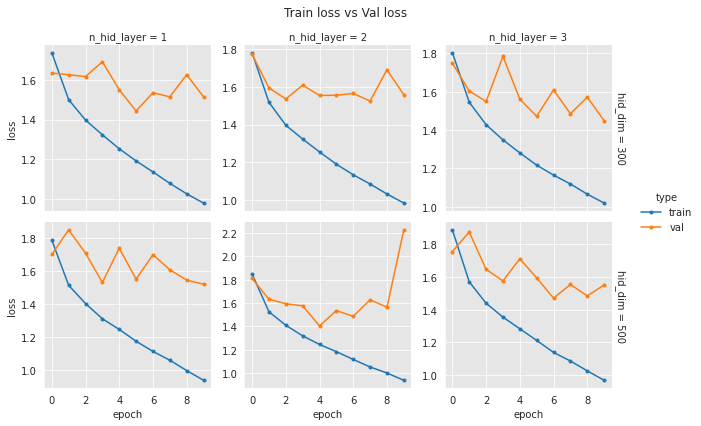

In [14]:
var1 = 'n_hid_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False) # FacetGrid : n_hid_layer, epoch에 따라 grid하게 그림그릴때 사용함!
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

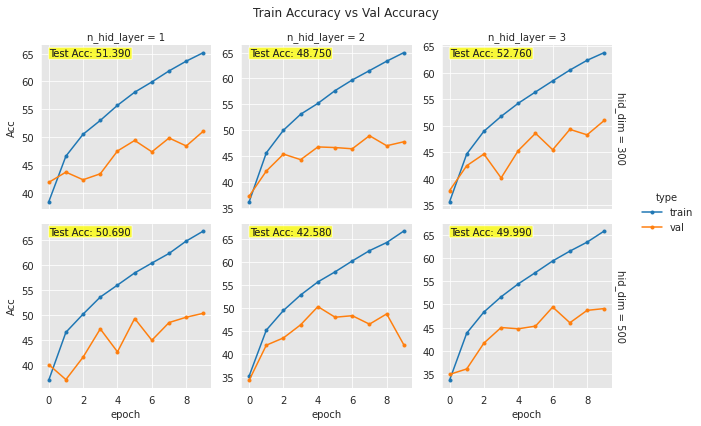

In [18]:
# test가 아니라 validate로 바꿔야함. 파라미터튜닝할때는 validate값을 기준으로 해야지.

var1 = 'n_hid_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)